In [ ]:
import pandas as pd


# Load the dataset
df = pd.read_csv('fer2013.csv')
df.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
import numpy as np

# Convert pixel string to array
df['pixels'] = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int))

# Normalize pixel values
df['pixels'] = df['pixels'].apply(lambda x: x / 255.0)

# One-hot encode emotion labels
from tensorflow.keras.utils import to_categorical

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df['emotion_cat'] = to_categorical(df['emotion'], num_classes=7).tolist()

# Separate train and test
train_df = df[df['Usage'] == 'Training']
val_df   = df[df['Usage'] == 'PublicTest']
test_df  = df[df['Usage'] == 'PrivateTest']


In [ ]:
# Prepare training data
X_train = np.stack(train_df['pixels'].values)
y_train = np.stack(train_df['emotion_cat'].values)

X_val = np.stack(val_df['pixels'].values)
y_val = np.stack(val_df['emotion_cat'].values)

X_test = np.stack(test_df['pixels'].values)
y_test = np.stack(test_df['emotion_cat'].values)

# Reshape for CNN
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,775 (3.42 MB)

 Trainable params: 895,879 (3.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=15,
                    batch_size=64)


Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 352s 776ms/step - accuracy: 0.2655 - loss: 1.9754 - val_accuracy: 0.2892 - val_loss: 1.7020
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 365s 740ms/step - accuracy: 0.3678 - loss: 1.5854 - val_accuracy: 0.4525 - val_loss: 1.4604
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 395s 768ms/step - accuracy: 0.4037 - loss: 1.4826 - val_accuracy: 0.4241 - val_loss: 1.5016
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 392s 790ms/step - accuracy: 0.4350 - loss: 1.4223 - val_accuracy: 0.4539 - val_loss: 1.3998
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 353s 786ms/step - accuracy: 0.4587 - loss: 1.3730 - val_accuracy: 0.3530 - val_loss: 1.6089
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 378s 777ms/step - accuracy: 0.4845 - loss: 1.3146 - val_accuracy: 0.5026 - val_loss: 1.3196
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 385s 784ms/step - accuracy: 0.4966 - loss: 1.2723 - val_accuracy: 0.3848 - val_loss: 1.5281
Epoch 8/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 384s 788ms/step - accuracy: 0.5159 -

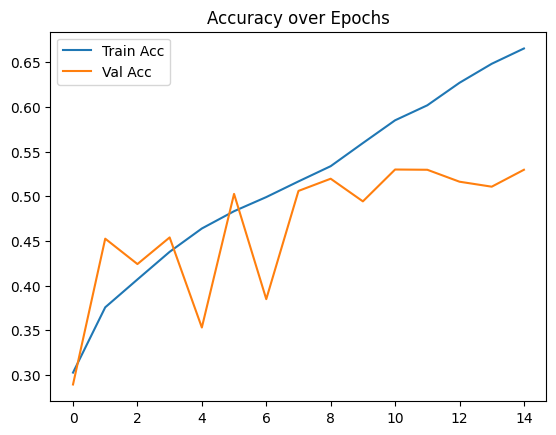

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.5272 - loss: 1.2577
Test Accuracy: 0.5291167497634888


In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


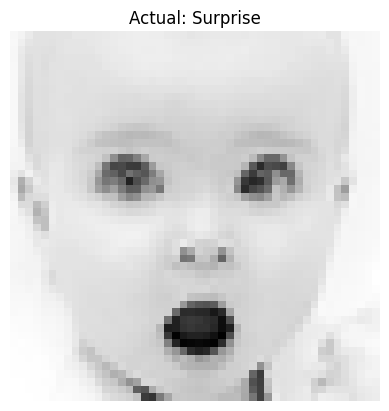

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predicted: Surprise


In [ ]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i].reshape(48,48), cmap='gray')
plt.title("Actual: " + emotion_labels[np.argmax(y_test[i])])
plt.axis('off')
plt.show()

pred = model.predict(np.expand_dims(X_test[i], axis=0))
print("Predicted:", emotion_labels[np.argmax(pred)])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Create an ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=15,       # Randomly rotate images by 15 degrees
    width_shift_range=0.1,   # Shift images horizontally by 10%
    height_shift_range=0.1,  # Shift images vertically by 10%
    zoom_range=0.1,          # Random zoom
    shear_range=0.1,         # Shear intensity
    horizontal_flip=True     # Flip images horizontally
)


In [ ]:
# Fit the data generator on your training set
datagen.fit(X_train.reshape(-1, 48, 48, 1))


In [ ]:
# Train model using augmented data
model.fit(datagen.flow(X_train.reshape(-1, 48, 48, 1), y_train, batch_size=64),
          validation_data=(X_test.reshape(-1, 48, 48, 1), y_test),
          epochs=15)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 367s 815ms/step - accuracy: 0.4214 - loss: 1.5496 - val_accuracy: 0.5433 - val_loss: 1.1936
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 362s 806ms/step - accuracy: 0.4658 - loss: 1.3902 - val_accuracy: 0.5308 - val_loss: 1.2478
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 378s 797ms/step - accuracy: 0.4962 - loss: 1.3337 - val_accuracy: 0.5099 - val_loss: 1.2866
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 357s 795ms/step - accuracy: 0.4959 - loss: 1.3327 - val_accuracy: 0.5681 - val_loss: 1.1475
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 360s 802ms/step - accuracy: 0.4979 - loss: 1.3367 - val_accuracy: 0.5595 - val_loss: 1.1488
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 358s 797ms/step - accuracy: 0.5164 - loss: 1.2827 - val_accuracy: 0.5394 - val_loss: 1.2086
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 358s 797ms/step - accuracy: 0.5216 - loss: 1.2748 - val_accuracy: 0.5472 - val_loss: 1.1845
Epoch 8/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 359s 799ms/step - accuracy: 0.5280 - loss: 1.26

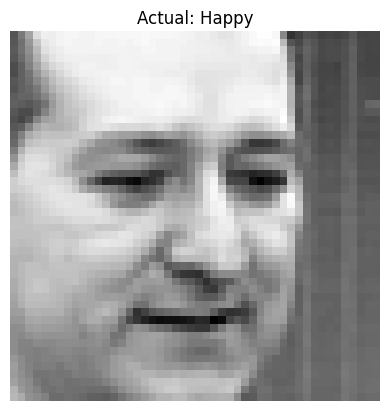

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: Happy


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Emotion class labels — adjust if you're using different labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Pick a random index from the test set
i = random.randint(0, len(X_test) - 1)

# Plot the test image
plt.imshow(X_test[i].reshape(48, 48), cmap='gray')
plt.title("Actual: " + emotion_labels[np.argmax(y_test[i])])
plt.axis('off')
plt.show()

# Predict emotion using the trained model
pred = model.predict(np.expand_dims(X_test[i].reshape(48, 48, 1), axis=0))
print("Predicted:", emotion_labels[np.argmax(pred)])


Saving EPE19062(Photo).jpeg to EPE19062(Photo).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


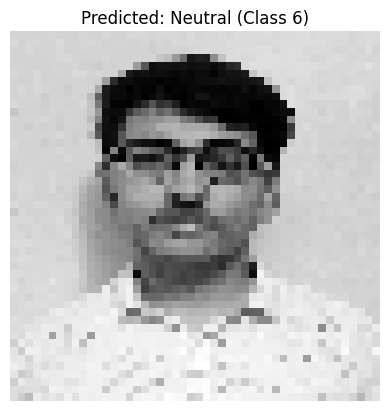

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files

# Upload an image
uploaded = files.upload()

# Read the uploaded image (first file)
for fname in uploaded.keys():
    img_path = fname
    break

# Read and preprocess the image
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)               # Convert to grayscale
gray_resized = cv2.resize(gray, (48, 48))                  # Resize to (48x48)
gray_normalized = gray_resized.astype('float32') / 255.0   # Normalize
gray_input = gray_normalized.reshape(1, 48, 48, 1)          # Reshape for model

# Predict
pred_probs = model.predict(gray_input)
pred_label = np.argmax(pred_probs)

# Emotion labels (adjust if needed)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Show prediction
plt.imshow(gray_resized, cmap='gray')
plt.title(f"Predicted: {emotion_labels[pred_label]} (Class {pred_label})")
plt.axis('off')
plt.show()


Saving EPE19062(Photo).jpg to EPE19062(Photo) (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


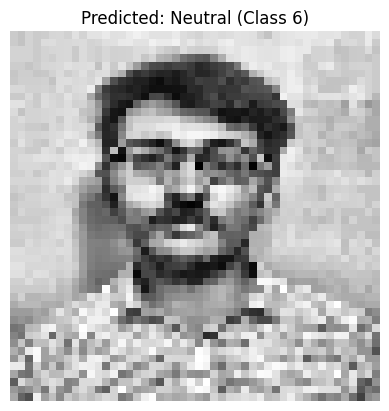

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files

# Upload image from your system
uploaded = files.upload()

# Load the uploaded image
for fname in uploaded.keys():
    img_path = fname
    break

# Read the image using OpenCV
img = cv2.imread(img_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Resize to 48x48 as expected by model
gray_resized = cv2.resize(gray, (48, 48))

# Apply CLAHE (same as you did in augmentation)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_clahe = clahe.apply(gray_resized)

# Normalize to [0,1] range (same as training)
gray_normalized = gray_clahe.astype('float32') / 255.0

# Reshape for model input: (1, 48, 48, 1)
gray_input = gray_normalized.reshape(1, 48, 48, 1)

# Load trained model (if not already loaded)
# model = load_model('your_model_path.h5')  # Uncomment if needed

# Predict emotion
pred_probs = model.predict(gray_input)
pred_label = np.argmax(pred_probs)

# Emotion class labels (adjust if your mapping is different)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Show results
plt.imshow(gray_clahe, cmap='gray')
plt.title(f"Predicted: {emotion_labels[pred_label]} (Class {pred_label})")
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_images = []

    for img in tqdm(images):
        img_uint8 = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
        enhanced_img = clahe.apply(img_uint8)
        enhanced_images.append(enhanced_img)

    return np.array(enhanced_images)

# Apply CLAHE to training and test images
X_train_clahe = apply_clahe(X_train.reshape(-1, 48, 48))
X_test_clahe = apply_clahe(X_test.reshape(-1, 48, 48))


100%|██████████| 3589/3589 [00:00<00:00, 10327.13it/s]


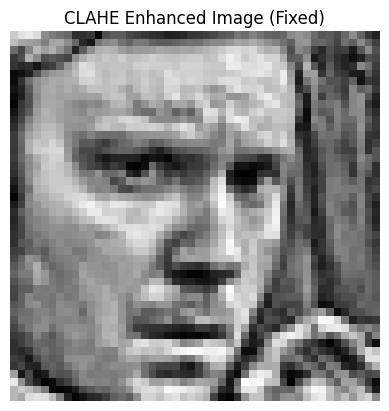

In [ ]:
plt.imshow(X_train_clahe[0], cmap='gray')
plt.title("CLAHE Enhanced Image (Fixed)")
plt.axis('off')
plt.show()


In [ ]:
X_train_ready = X_train_clahe.reshape(-1, 48, 48, 1)
X_test_ready = X_test_clahe.reshape(-1, 48, 48, 1)


In [ ]:
X_train_ready = X_train_ready.astype('float32') / 255.0
X_test_ready = X_test_ready.astype('float32') / 255.0


In [ ]:
model.fit(datagen.flow(X_train_ready, y_train, batch_size=64),
          validation_data=(X_test_ready, y_test),
          epochs=15)


Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 357s 793ms/step - accuracy: 0.5449 - loss: 1.2170 - val_accuracy: 0.5804 - val_loss: 1.1047
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 355s 790ms/step - accuracy: 0.5450 - loss: 1.1987 - val_accuracy: 0.5461 - val_loss: 1.1759
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 386s 800ms/step - accuracy: 0.5569 - loss: 1.1897 - val_accuracy: 0.5910 - val_loss: 1.0787
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 355s 790ms/step - accuracy: 0.5542 - loss: 1.1920 - val_accuracy: 0.5876 - val_loss: 1.0825
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 358s 797ms/step - accuracy: 0.5553 - loss: 1.1895 - val_accuracy: 0.5907 - val_loss: 1.0900
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 359s 799ms/step - accuracy: 0.5591 - loss: 1.1656 - val_accuracy: 0.5665 - val_loss: 1.1435
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 355s 791ms/step - accuracy: 0.5660 - loss: 1.1557 - val_accuracy: 0.5456 - val_loss: 1.1651
Epoch 8/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 357s 795ms/step - accuracy: 0.5715 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


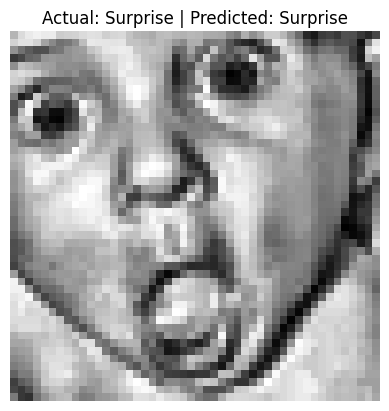

In [ ]:
import random
import matplotlib.pyplot as plt

# Emotion label list (make sure this matches your label order)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Pick a random index from test set
i = random.randint(0, len(X_test_ready) - 1)

# Predict using the trained model
pred = model.predict(X_test_ready[i].reshape(1, 48, 48, 1))
predicted_class = np.argmax(pred)
actual_class = np.argmax(y_test[i])

# Show image and prediction
plt.imshow(X_test_ready[i].reshape(48, 48), cmap='gray')
plt.title(f"Actual: {emotion_labels[actual_class]} | Predicted: {emotion_labels[predicted_class]}")
plt.axis('off')
plt.show()


Saving photograph (2).jpg to photograph (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


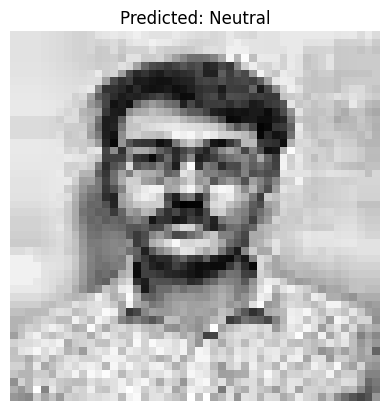

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload an image
uploaded = files.upload()

# Use the first uploaded image
for fname in uploaded.keys():
    img_path = fname
    break

# Read the image
img = cv2.imread(img_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Resize to 48x48 (FER-2013 format)
gray_resized = cv2.resize(gray, (48, 48))

# Apply CLAHE (same as used in training)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_clahe = clahe.apply(gray_resized)

# Normalize and reshape
img_input = gray_clahe.astype('float32') / 255.0
img_input = img_input.reshape(1, 48, 48, 1)  # For model input

# Predict using the trained model
pred_probs = model.predict(img_input)
pred_class = np.argmax(pred_probs)

# Emotion labels (make sure order matches your training labels)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Show result
plt.imshow(gray_clahe, cmap='gray')
plt.title(f"Predicted: {emotion_labels[pred_class]}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


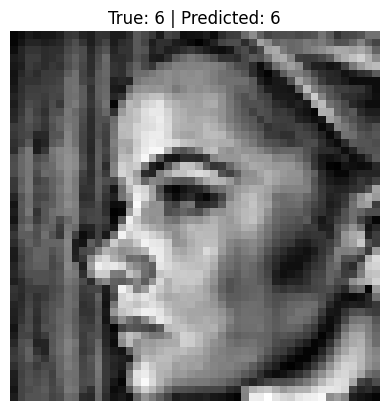

In [ ]:
import random

# Pick a random image
index = random.randint(0, len(X_test_ready) - 1)
img = X_test_ready[index]
true_label = np.argmax(y_test[index])

# Predict
pred = model.predict(img.reshape(1, 48, 48, 1))
predicted_label = np.argmax(pred)

# Plot image with prediction
plt.imshow(img.reshape(48, 48), cmap='gray')
plt.title(f"True: {true_label} | Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_ready)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=emotion_labels))


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step
              precision    recall  f1-score   support

       Angry       0.48      0.44      0.46       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.34      0.43      0.38       528
       Happy       0.85      0.75      0.79       879
         Sad       0.48      0.26      0.34       594
    Surprise       0.68      0.69      0.69       416
     Neutral       0.47      0.72      0.57       626

    accuracy                           0.55      3589
   macro avg       0.47      0.47      0.46      3589
weighted avg       0.56      0.55      0.55      3589



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


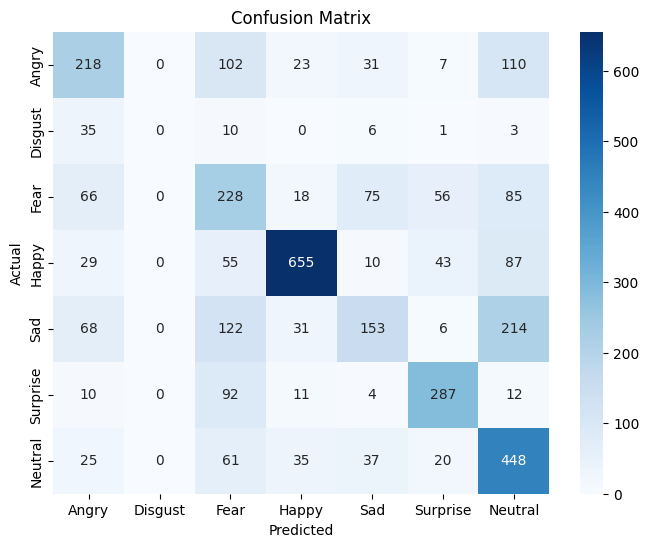

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("emotion_model_clahe_augmented.h5")
